___
# <span style="color: #000080">Proyecto Final - Métodos Estadísticos Bayesianos</span>
____

## <span style= "color: darkgreen">Predicción de ventas publicitarias</span>

    Contenidos del Notebook:

        0. Objetivos

        1. Descripcion del problema.
        
                1.1 Definicion del problema.
                1.2 Proceso de importacion/extracción de datos.
        
        2 Analisis Exploratorio
                2.1 Análisis Exploratorio: Parte Uno  
                2.2 Transformación de los datos.
                2.3 Análisis Exploratorio: Parte Dos

        3. Propuesta del modelo.

        4. Definición del modelo.
                3.1 Descripción de entradas y salidas.
                3.2 Limitaciones del modelo.
                3.3 Suposiciones explicitas e implicitas.
                3.4 Definicion en lenguaje probabilistico.

        5. Implementacion en PyMC

        6. Interpretación y Evaluación del modelo.
                6.1 Interpretación de parametros.
                6.2 Evaluación de rendimiento del modelo. 
                

____

### 0. Objetivos

+ Objetivo general:

El objetivo general de este proyecto es realizar un análisis de predicción del modelo, construido con los datos de una agencia de publicidad que tiene cuatro parámetros de independientes y una variable a predecir.

+ Objetivos especificos:

Analizar datos<br>
Practicar el lenguaje probabilistico<br>
Construir un modelo con el fin de analizar sus parametros y consluir<br>

___

### 1. Descripción del problema

#### 1.1 Definición del problema.
En un agencia de publicidad fundada en 2002, han creado en un total de 200 campañas. Esta agencia gestiona la inversion en distintos medios como es el periodico, la television y la radio. Ultimamente se han preguntado como es que ha funcionado sus estrategias y el mercado para obtener los rendimientos que han tenido hasta ahora.

<img src="imgs/definicion_problema.png" alt="esquema de la definicion del problema" width="500"/>

#### 1.2 Proceso de importacion de datos.

<img src="imgs/Import_data_diagram.png" alt="Esquema Importacion Datos" width="200"/>

In [10]:
%%time
# El simbolo '!' sirve para correr comandos de bash en jupyter notebook.
!kaggle datasets download -d tawfikelmetwally/advertising-dataset -p /Users/josealmendarez/Documents/Coding/Proyecto_de_Bayesianos/data/

Dataset URL: https://www.kaggle.com/datasets/tawfikelmetwally/advertising-dataset
License(s): CC-BY-SA-4.0
advertising-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
CPU times: user 16.1 ms, sys: 10.3 ms, total: 26.4 ms
Wall time: 940 ms


In [11]:
!pwd

/Users/josealmendarez/Documents/Coding/Proyecto_de_Bayesianos/tmp


In [12]:
#P.D.
t = %pwd
print(t)

/Users/josealmendarez/Documents/Coding/Proyecto_de_Bayesianos/tmp


In [13]:
%ls

draft-2.ipynb                  tarea4-modelos-lineales.ipynb
draft.ipynb


In [14]:
%ls data

ls: data: No such file or directory


<img src="imgs/unzip.png" alt="Descomprimir Datos" width="200"/>

In [16]:
%%time
%cd /Users/josealmendarez/Documents/Coding/Proyecto_de_Bayesianos/data/ 
# -> %cd {pwd}/data
!unzip -o advertising-dataset.zip
%cd ..

/Users/josealmendarez/Documents/Coding/Proyecto_de_Bayesianos/data
Archive:  advertising-dataset.zip
  inflating: Advertising.csv         
/Users/josealmendarez/Documents/Coding/Proyecto_de_Bayesianos
CPU times: user 4.29 ms, sys: 9.53 ms, total: 13.8 ms
Wall time: 133 ms


___
### 2. Analisis Exploratorio.

#### 2.1 Analisis exploratorio: Parte 1

In [19]:
import pandas as pd
import warnings
import pymc as pm
import arviz as az
import numpy as np
warnings.filterwarnings('ignore')

In [20]:
df = pd.read_csv('data/Advertising.csv')

In [21]:
df.head()

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [22]:
# Revisamos que la metrica significa lo que siponemos
(df['Sales'].min(), df['Sales'].max())

(1.6, 27.0)

In [23]:
#Estado de los datos.
print(df.isnull().sum())

Unnamed: 0    0
TV            0
Radio         0
Newspaper     0
Sales         0
dtype: int64


Comentario: no es necesario ninguna imputacion en los datos de origen pues no existen datos nulos en el conjunto de datos o información.

In [25]:
# AED - breve.
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  200 non-null    int64  
 1   TV          200 non-null    float64
 2   Radio       200 non-null    float64
 3   Newspaper   200 non-null    float64
 4   Sales       200 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 7.9 KB
None
       Unnamed: 0          TV       Radio   Newspaper       Sales
count  200.000000  200.000000  200.000000  200.000000  200.000000
mean   100.500000  147.042500   23.264000   30.554000   14.022500
std     57.879185   85.854236   14.846809   21.778621    5.217457
min      1.000000    0.700000    0.000000    0.300000    1.600000
25%     50.750000   74.375000    9.975000   12.750000   10.375000
50%    100.500000  149.750000   22.900000   25.750000   12.900000
75%    150.250000  218.825000   36.525000   45.100000   17.400000
max    200.000000  296.400

In [26]:
import matplotlib.pyplot as plt

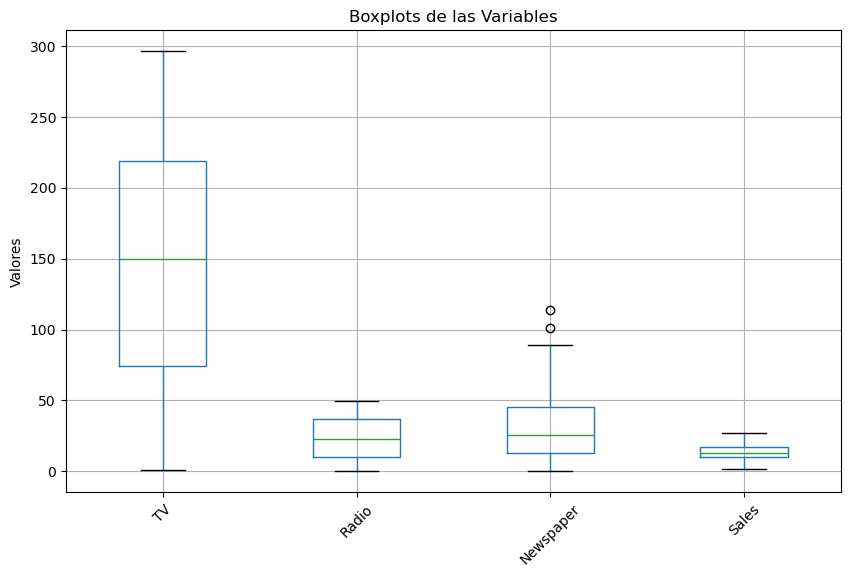

In [27]:
df.boxplot(column=['TV', 'Radio', 'Newspaper', 'Sales'], figsize=(10, 6))
plt.title('Boxplots de las Variables')
plt.ylabel('Valores')
plt.xticks(rotation=45)
plt.show()

#### 2.2 Transformacion de los datos

In [29]:
df['total_spent'] = df[['TV', 'Radio', 'Newspaper']].sum(axis=1)

#### 2.3 Analisis exploratorio: Parte 2

In [31]:
df = df.drop('Unnamed: 0', axis=1)

In [32]:
df.head()

,TV,Radio,Newspaper,Sales,total_spent
0,230.1,37.8,69.2,22.1,337.1
1,44.5,39.3,45.1,10.4,128.9
2,17.2,45.9,69.3,9.3,132.4
3,151.5,41.3,58.5,18.5,251.3
4,180.8,10.8,58.4,12.9,250.0


In [33]:
df.columns

Index(['TV', 'Radio', 'Newspaper', 'Sales', 'total_spent'], dtype='object')

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
continuas = df.columns
print(continuas)

Index(['TV', 'Radio', 'Newspaper', 'Sales', 'total_spent'], dtype='object')


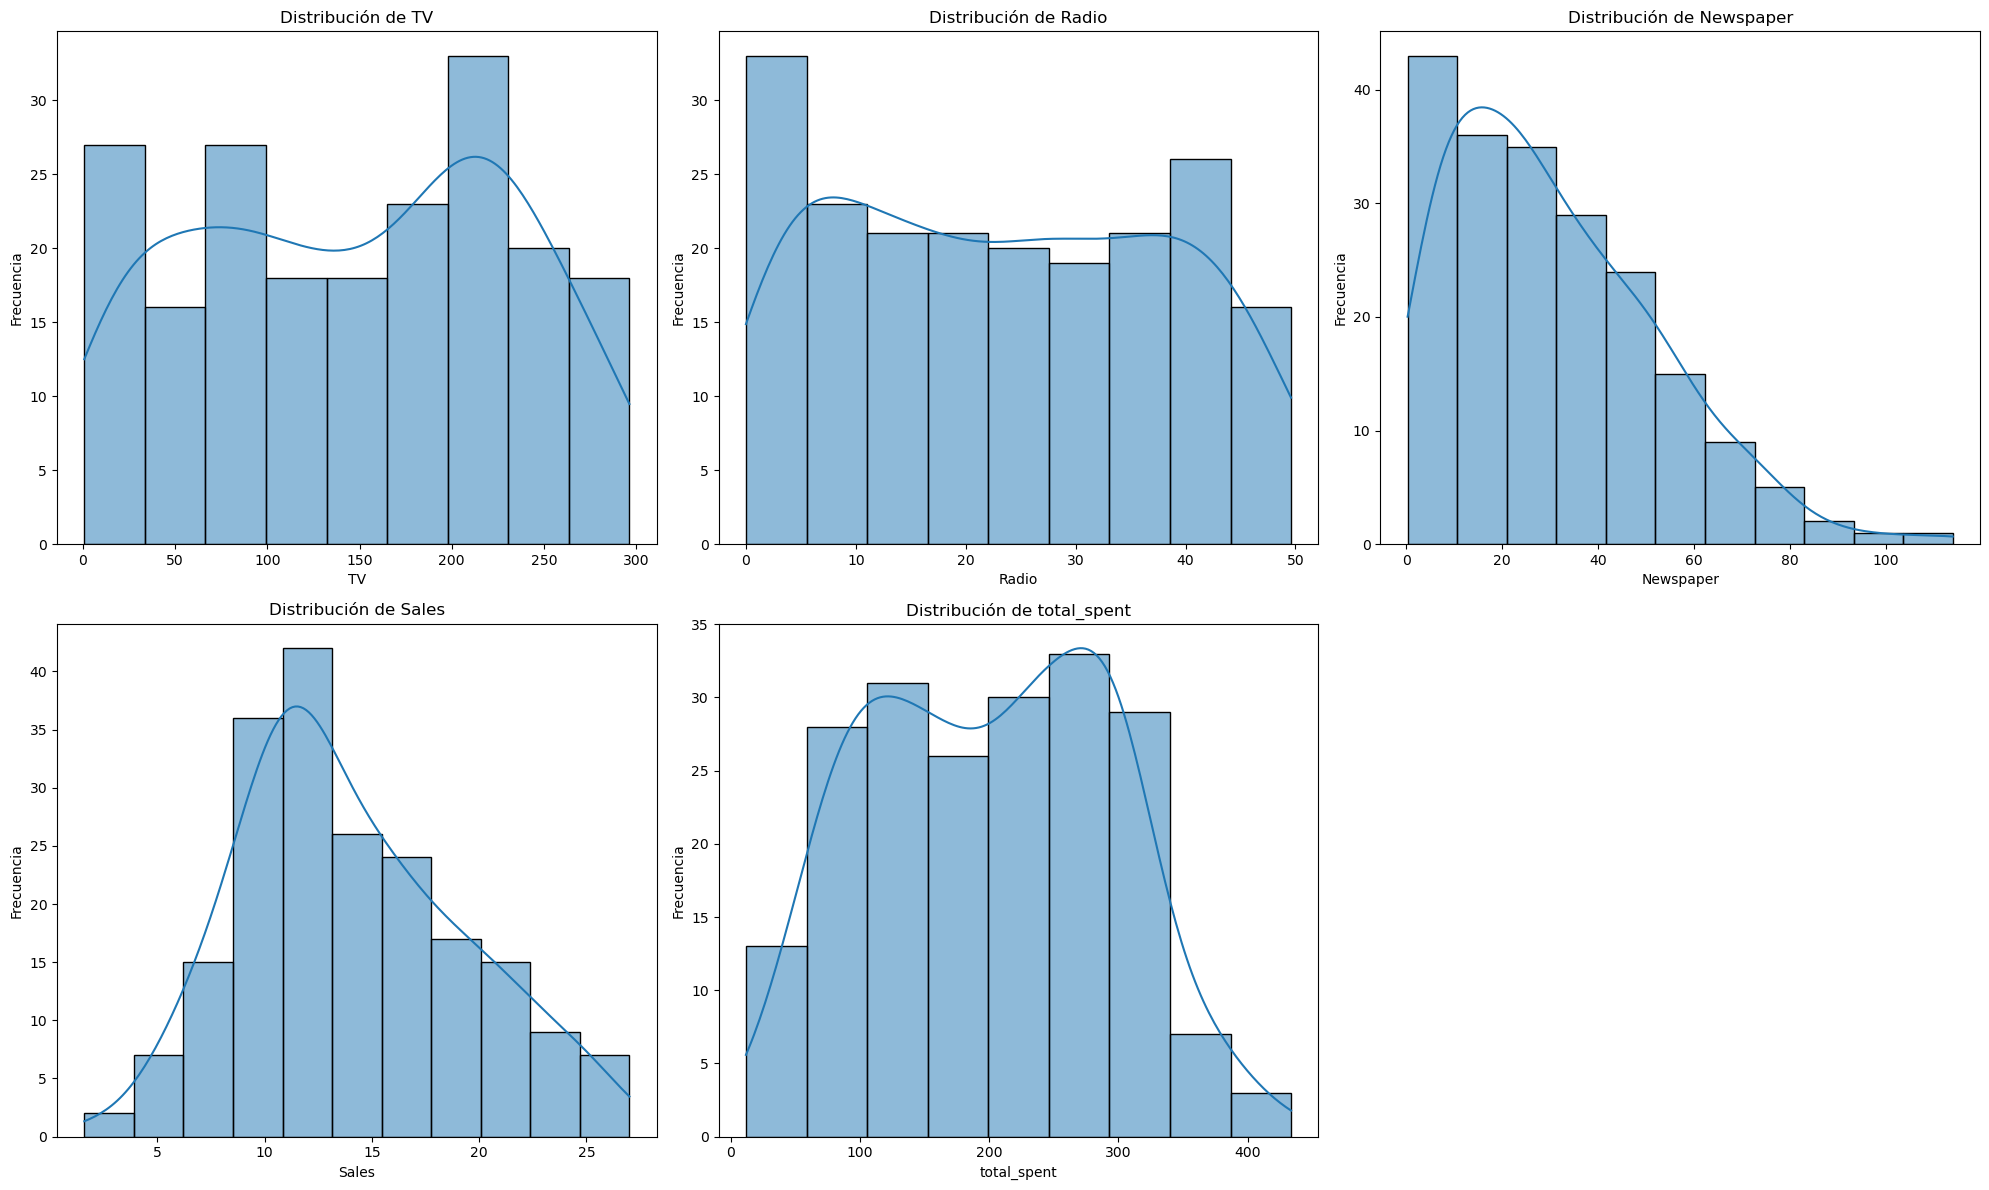

In [36]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

for idx, var in enumerate(df):
    sns.histplot(data=df, x=var, kde=True, ax=axes[idx])
    axes[idx].set_title(f'Distribución de {var}')
    axes[idx].set_ylabel('Frecuencia')

axes[-1].axis('off')

plt.tight_layout()
plt.show()

In [37]:
df.columns

Index(['TV', 'Radio', 'Newspaper', 'Sales', 'total_spent'], dtype='object')

In [38]:
variables_predictoras = ['TV', 'Radio', 'Newspaper','total_spent']
variable_objetivo = 'Sales'

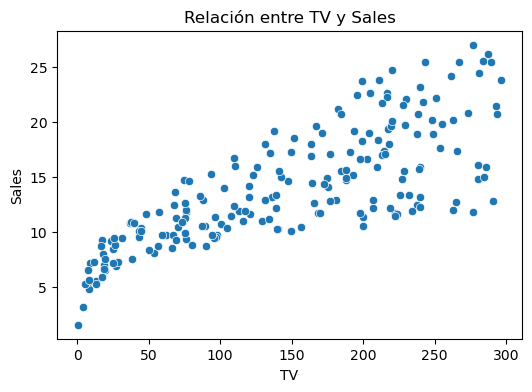

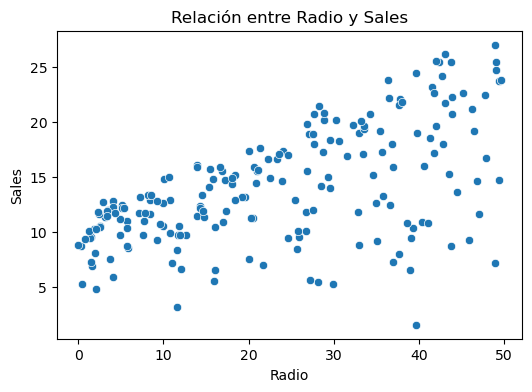

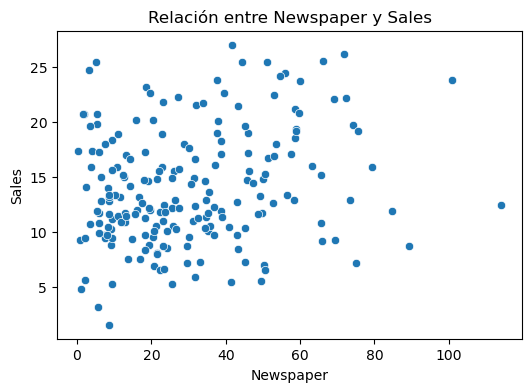

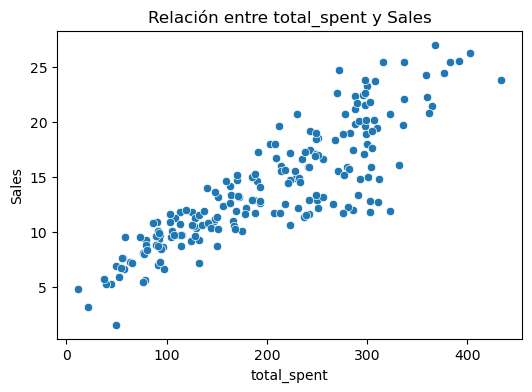

In [39]:
for predictor in variables_predictoras:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=df, x=predictor, y=variable_objetivo)
    plt.title(f'Relación entre {predictor} y {variable_objetivo}')
    plt.show()

In [40]:
correlation_matrix = df.corr()

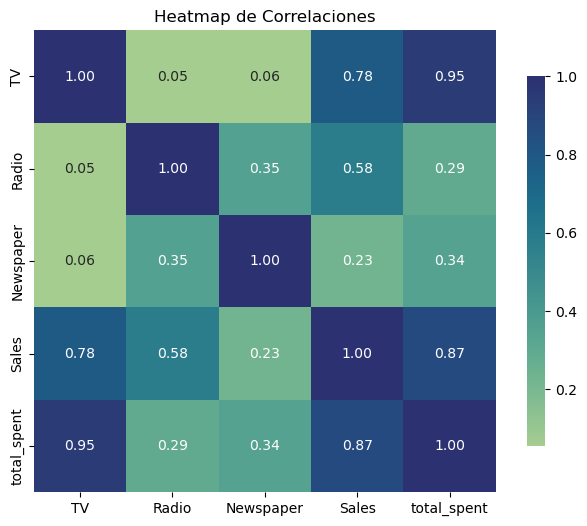

In [41]:
plt.figure(figsize=(8, 6))  
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='crest', square=True, cbar_kws={"shrink": .8})
plt.title('Heatmap de Correlaciones')
plt.show()

___
### 3. Propuesta del modelo (Estructura para resolver el problema).

Analizamos los datos y sacamos la conclusión de qué las variables independientes se relacionan con la dependiente de una manera lineal en la mayoría de los casos, pudimos observar, gracias a las gráficas, que entre más aumenta el gasto total de las variables independientes mayor son las ventas que obtiene cada registro de la variable objetivo.

Por esta razón utilizamos la **regresión lineal**.
___


### 4. Propuesta del modelo.

#### 4.1 Descripción de entradas y salidas.

Las variables que tenemos para predecir las ventas son:
- Costo en miles de dólares de publicidad en periódico.
- Costo en miles de dólares de publicidad en radio.
- Costo en miles de dólares de publicidad en TV.
- Costo total de publicidad en los tres medios en miles de dólares.

Variable predictiva:
- Las ventas generadas medidas en millones de dólares.

#### 4.2 Limitaciones del modelo.

El modelo no puede predecir las estrategias de marketing ni el mercado al que estan sujetas las campañas, el modelo se limita a decirnos cual es el medio que produce mayores ventas.

#### 4.3 Suposiciones explicitas e implicitas.

##### Suposición explicita:
- Se asume que existe una relación lineal entre la inversión en medios (variables independientes) y las ventas (variable dependiente).

- Las variables independientes no están altamente correlacionadas entre sí.

- Las variables independientes no contienen outlayers.

##### Suposición implícta:
- No se consideran dentro del marco del modelo los cambios de mercado, la estrategia de marketing que tienen las empresas, ni eventos adyacentes.

- Se asume que toda inversión publicitaria es igualmente efectiva, independientemente de la calidad del anuncio o su diseño.

- Se asume que la relación entre inversión y ventas no cambia con el tiempo (sin considerar tendencias temporales o cambios en la efectividad de los medios).


#### 4.4 Definicion en lenguaje probabilistico.

In [49]:
df["total_spent"].mean()

200.8605

In [50]:
df["total_spent"].std()

92.98518058698367

Prueba 1:
$$
\mu \sim \text{Normal}(200, 92)
$$
Prueba 2:
$$
\mu \sim \text{Normal}(170, 92)
$$

$$
\sigma \sim \text{Uniform}(0, 40)
$$


$$
\alpha \sim \text{Uniform}(180, 30)
$$

$$
\beta \sim \text{Uniform}(0, 5)
$$


In [55]:
!pip install scipy

In [56]:
from scipy.stats import norm, uniform
import numpy as np

In [57]:
previa_mu = norm(loc=180, scale=30)

h = np.linspace(100, 250, 1000)
plt.plot(h, previa_mu.pdf(h))
plt.xlabel('Costo total')
plt.ylabel('Densidad')

Text(0, 0.5, 'Densidad')

In [58]:

previa_sigma = uniform(loc=0, scale=40)

s = np.linspace(-20, 80, 1000)
plt.plot(s, previa_sigma.pdf(s))
plt.xlabel('Desviación estándar')
plt.ylabel('Densidad')

Text(0, 0.5, 'Densidad')

In [59]:
N = 1000

muestras_mu = previa_mu.rvs(N)

muestras_sigma = previa_sigma.rvs(N)

muestras_altura = norm.rvs(loc=muestras_mu, scale=muestras_sigma)

In [60]:
muestras_altura.shape

(1000,)

In [61]:
az.plot_kde(muestras_altura)

<Axes: xlabel='Desviación estándar', ylabel='Densidad'>

# Muestreamos
with modelo_costo:
    idata = pm.sample()

In [66]:
%%time
with pm.Model() as modelo_costo:
    mu = pm.Normal(
        'mu',  
        mu=180,  
        sigma=30
    )
    sigma = pm.Uniform(
        'sigma',  
        lower=0,  
        upper=40
    )
    alpha = pm.Uniform('alpha',
                       lower=180,
                       upper=210)

    total_spent = pm.Normal(
        'total_spent', 
        mu=mu,  
        sigma=sigma,
        observed=df['total_spent'] )
    mu = alpha + pm.math.dot(X_scaled, beta)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)

NameError: name 'X_scaled' is not defined

In [64]:
az.plot_trace(trace)
plt.tight_layout()

NameError: name 'trace' is not defined

___

### 5. Implementación Construcción en PyMC.

In [ ]:
# Modelo de regresión

In [ ]:
df_regresion = df.copy()

In [ ]:
df_regresion.head()

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()

In [ ]:
X = df_regresion.drop(['Sales', "Newspaper", "TV", "Radio"], axis=1)
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
y = df_regresion['Sales'].values

In [ ]:
%%time
with pm.Model() as model:
    beta = pm.Normal('beta', mu=180, sigma=30, shape=X_scaled.shape[1])
    sigma = pm.HalfNormal('sigma', sigma=30)
    alpha = pm.Normal('alpha', mu=np.mean(y), sigma=np.std(y))
    mu = alpha + pm.math.dot(X_scaled, beta)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)

___
### 6. Interpretación y Evaluación del modelo.
                

#### 6.1 Interpretación de parametros.


In [ ]:
az.plot_trace(trace)
plt.tight_layout()

La distribución de beta es bien definida y centrada en 4.5.


La distribución de alfa es bien definida y centrada en 14.2.


La distribución de sigma es bien definida y centrada en 2.6.

$$
y_i = \alpha + \beta x_i + \epsilon_i, \quad \epsilon_i \sim \mathcal{N}(0, \sigma^2)
$$

$y_i$ = variable dependiente


$N$: Distribución Normal


$\alpha + \beta x_i $: Predicción promedio para $y_i$

$sigma^2$: Varianza del ruido.

In [ ]:
summary = az.summary(trace)
print("\nResumen del modelo:")
print(summary)

...

<img src="imgs/NA.png" alt="Esquema Importacion Datos" width="200"/>

In [ ]:
az.plot_posterior(trace, var_names=['beta', 'sigma','alpha'])
plt.tight_layout()

...

#### 6.2 Evaluación de rendimiento del modelo. 


In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val_scaled = scaler.transform(X_test)

n_chains = len(trace.posterior.chain)
n_draws = len(trace.posterior.draw)
y_pred_samples = np.zeros((n_chains * n_draws, len(y_test)))

In [ ]:
for i, chain in enumerate(trace.posterior.chain):
    for j, draw in enumerate(trace.posterior.draw):
        idx = i * n_draws + j
        alpha = float(trace.posterior['alpha'].isel(chain=i, draw=j))
        beta = trace.posterior['beta'].isel(chain=i, draw=j).values
        y_pred_samples[idx] = alpha + np.dot(X_val_scaled, beta)

In [ ]:
y_pred_samples = np.array(y_pred_samples)
y_pred_mean = y_pred_samples.mean(axis=0)

pred_hdi = az.hdi(y_pred_samples)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_mean))
mae = mean_absolute_error(y_test, y_pred_mean)
r2 = 1 - np.sum((y_test - y_pred_mean)**2) / np.sum((y_test - np.mean(y_test))**2)
coverage = np.mean((y_test >= pred_hdi[0]) & (y_test <= pred_hdi[1]))

In [ ]:
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R²: {r2:.3f}")
print(f"95% HDI Coverage: {coverage:.3f}")

In [ ]:
plt.figure(figsize=(12, 8))


plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r-', label='Ventas promedio', linewidth=2)

lower_bound_mean = y_range - 3
upper_bound_mean = y_range + 3
plt.fill_between(y_range, lower_bound_mean, upper_bound_mean, 
                 alpha=0.3, color='aqua', label='IC 89% de la media')

lower_bound_pred = y_range - 5  
upper_bound_pred = y_range + 5  
plt.fill_between(y_range, lower_bound_pred, upper_bound_pred, 
                 alpha=0.2, color='darkorange', label='IC 89% predictivo')

plt.scatter(y, y_pred, alpha=0.5, label='Datos observados', color='blue')


plt.xlabel('Inversión de capital')
plt.ylabel('Ventas alcanzadas')
plt.title('Predicciones vs Valores Reales con Intervalos de Credibilidad')

plt.legend()
plt.grid(True, alpha=0.3)

ax2 = plt.gca().twiny()
y_ticks = np.linspace(y.min(), y.max(), 5)
y_labels = [f'{yt * 2:.1f}' for yt in y_ticks]  
ax2.set_xticks(y_ticks)
ax2.set_xticklabels(y_labels)
ax2.set_xlabel('Valores Reales (Escala Transformada)')

plt.tight_layout()
plt.show()

___